In [1]:
import random

def generateData(machines=4, jobs=7, seed=0):
    PROC = [ [ 0 for m in range(machines) ] for j in range(jobs) ]
    random.seed(seed)
    for j in range(jobs):
        for m in range(machines):
            PROC[j][m] = random.randint(1,9)
    return PROC

In [2]:
import pulp

def IP(PROC):

    steps = [ len(job) for job in PROC ]
    assert(min(steps)==max(steps))
    N_MACHINES = len(PROC[0])
    N_JOBS = len(PROC)


    def val(x):
        return int(pulp.value(x))

    def proc(job, machine):
        return pulp.lpSum( [ PROC[j][machine] * JJ[job][j] for j in range(N_JOBS) ] ) 

    JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)), lowBound=0, upBound=1, cat='Integer')
    Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')

    prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)
    prob += Stop[N_JOBS-1][N_MACHINES-1]

    # JJ is a permutation of the jobs
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
        prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            prob += Start[j][m] + proc(j,m) == Stop[j][m]

    solvers = pulp.listSolvers(onlyAvailable=True) 
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
                
    return acc, int(pulp.value(prob.objective))

In [3]:
import numpy as np

def totalTime(PROC, seq, log=False):
    
    def isPermutation(seq):
        for i in range(len(seq)):
            if i not in seq:
                return False
        return True
    
    steps = [ len(job) for job in PROC ]
    assert(len(PROC) == len(seq))
    assert(isPermutation(seq))
    assert(min(steps)==max(steps))
    n_machines = len(PROC[0])
    n_jobs = len(PROC)
    wait = np.zeros([n_jobs, n_machines], dtype=int)
    idle = np.zeros([n_jobs, n_machines], dtype=int)
    start = np.zeros([n_jobs, n_machines], dtype=int)
    stop  = np.zeros([n_jobs, n_machines], dtype=int)
    proc = np.zeros([n_jobs, n_machines], dtype=int)
    for job in range(n_jobs):
        proc[job] = PROC[seq[job]]
    for job in range(n_jobs):
        for machine in range(n_machines):
            start[job, machine] = max(stop[job-1, machine] if job>0 else 0, stop[job, machine-1] if machine>0 else 0)
            wait[job, machine] = start[job, machine] - (stop[job, machine-1] if machine>0 else 0)
            idle[job, machine] = start[job, machine] - (stop[job-1, machine] if job>0 else 0)
            stop[job, machine] = start[job, machine] + proc[job, machine]

    if log:

        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)
        
        row = '|         |'
        for m in range(n_machines):
            row += f"            |" \
                    f" Machine: {m:1d} |"
        print(row)
        
        for j in range(n_jobs):
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Idle: {idle[j,m]:4d} |"
            print(row)
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Start:{start[j,m]:4d} |"  
            print(row)
            
            row = f'| Job: {seq[j]:2d} |'
            for m in range(n_machines):
                row += f" Wait: {wait[j,m]:4d} | " \
                       f"Proc: {proc[j,m]:4d} |"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Stop: {stop[j,m]:4d} |"  
            print(row)
            
        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)

    
    return stop[n_jobs-1, n_machines-1]                                                       

In [4]:
PROC = generateData(machines=4, jobs=7, seed=8215)

Compute the optimal job schedule:

In [5]:
seq, proctime = IP(PROC)
print(seq)
print(proctime)

[6, 4, 5, 1, 2, 3, 0]
56


Check the processing time and print the schedule

In [6]:
totalTime(PROC, seq)

56

In [7]:
totalTime(PROC, seq, log=True)

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    3 |            | Idle:    9 |            | Idle:   12 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   3 |            | Start:   9 |            | Start:  12 |
| Job:  6 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    6 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    6 |
|         |            | Stop:    3 |            | Stop:    9 |            | Stop:   12 |            | Stop:   18 |
|---------|------------|------------|------------|------------|---------

56

In [8]:
print(PROC)

[[5, 5, 2, 5], [7, 9, 9, 6], [3, 9, 4, 5], [8, 4, 1, 6], [2, 1, 6, 5], [4, 6, 6, 8], [3, 6, 3, 6]]


## Implementing Greedy Algorithm

In [9]:
def greedy_algorithm(PROC):
    n_jobs = len(PROC)
    seq = []
    remaining_jobs = set(range(n_jobs))
    
    for _ in range(n_jobs):
        next_job = min(remaining_jobs, key=lambda j: PROC[j][0])
        seq.append(next_job)
        remaining_jobs.remove(next_job)
    
    return seq

In [10]:
import matplotlib.pyplot as plt

def plot_job_durations(PROC, sequence):
    job_durations = [sum(PROC[job]) for job in sequence]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(sequence)), job_durations, tick_label=[f'Job {i}' for i in sequence], color='skyblue', edgecolor='black')

    plt.xlabel('Jobs', fontsize=14)
    plt.ylabel('Total Duration', fontsize=14)
    plt.title('Job Durations', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

In [11]:
def plot_machine_utilization(PROC, sequence):
    num_machines = len(PROC[0])
    utilization = [0] * num_machines
    
    for job in sequence:
        for m in range(num_machines):
            utilization[m] += PROC[job][m]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(num_machines), utilization, tick_label=[f'Machine {i+1}' for i in range(num_machines)], color='lightcoral', edgecolor='black')

    plt.xlabel('Machines', fontsize=14)
    plt.ylabel('Total Processing Time', fontsize=14)
    plt.title('Machine Utilization', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_completion_times(PROC, sequence):
    num_machines = len(PROC[0])
    completion_times = [[] for _ in range(num_machines)]
    start_times = [0] * num_machines
    
    for job in sequence:
        for m in range(num_machines):
            start_time = start_times[m]
            duration = PROC[job][m]
            completion_times[m].append((start_time, start_time + duration))
            start_times[m] += duration
    
    plt.figure(figsize=(10, 6))
    for m in range(num_machines):
        times = completion_times[m]
        for start, end in times:
            plt.plot([start, end], [m, m], marker='o', markersize=5, label=f'Machine {m+1}' if len(times) == 1 else "")
    
    plt.xlabel('Time')
    plt.ylabel('Machines')
    plt.title('Completion Times of Jobs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def print_schedule(PROC, job_order, show_idle_times=False, detailed=True, include_summary=False):
    N_JOBS = len(PROC)
    N_MACHINES = len(PROC[0])

    start_time = [[0] * N_MACHINES for _ in range(N_JOBS)]
    stop_time = [[0] * N_MACHINES for _ in range(N_JOBS)]

    for job_index in range(N_JOBS):
        job = job_order[job_index]
        for machine in range(N_MACHINES):
            if machine == 0:
                start_time[job][machine] = stop_time[job_order[job_index-1]][machine] if job_index > 0 else 0
            else:
                start_time[job][machine] = max(stop_time[job][machine-1], stop_time[job_order[job_index-1]][machine] if job_index > 0 else 0)
            stop_time[job][machine] = start_time[job][machine] + PROC[job][machine]

    if include_summary:
        total_time = max(stop_time[job_order[-1]][-1] for job in job_order)

    print("Detailed Schedule:")
    for job in job_order:
        print(f"Job {job}: ", end="")
        for machine in range(N_MACHINES):
            start = start_time[job][machine]
            stop = stop_time[job][machine]
            if show_idle_times and (machine > 0 and start > stop_time[job][machine - 1]):
                idle_time = start - stop_time[job][machine - 1]
                print(f"[Idle: {idle_time}] ", end="")
            print(f"[Start: {start}, Stop: {stop}] ", end="")
        print()

In [14]:
greedy_schedule = greedy_algorithm(PROC)
print("Greedy Algorithm Schedule:", greedy_schedule)
print("Total Time (Greedy):", totalTime(PROC, greedy_schedule,log=True))
print_schedule(PROC, greedy_schedule, show_idle_times=True, include_summary=True)

Greedy Algorithm Schedule: [4, 2, 6, 5, 0, 1, 3]
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    2 |            | Idle:    3 |            | Idle:    9 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   2 |            | Start:   3 |            | Start:   9 |
| Job:  4 | Wait:    0 | Proc:    2 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    6 | Wait:    0 | Proc:    5 |
|         |            | Stop:    2 |            | Stop:    3 |            | Stop:    9 |            | Stop:   14 |
|---------|------------

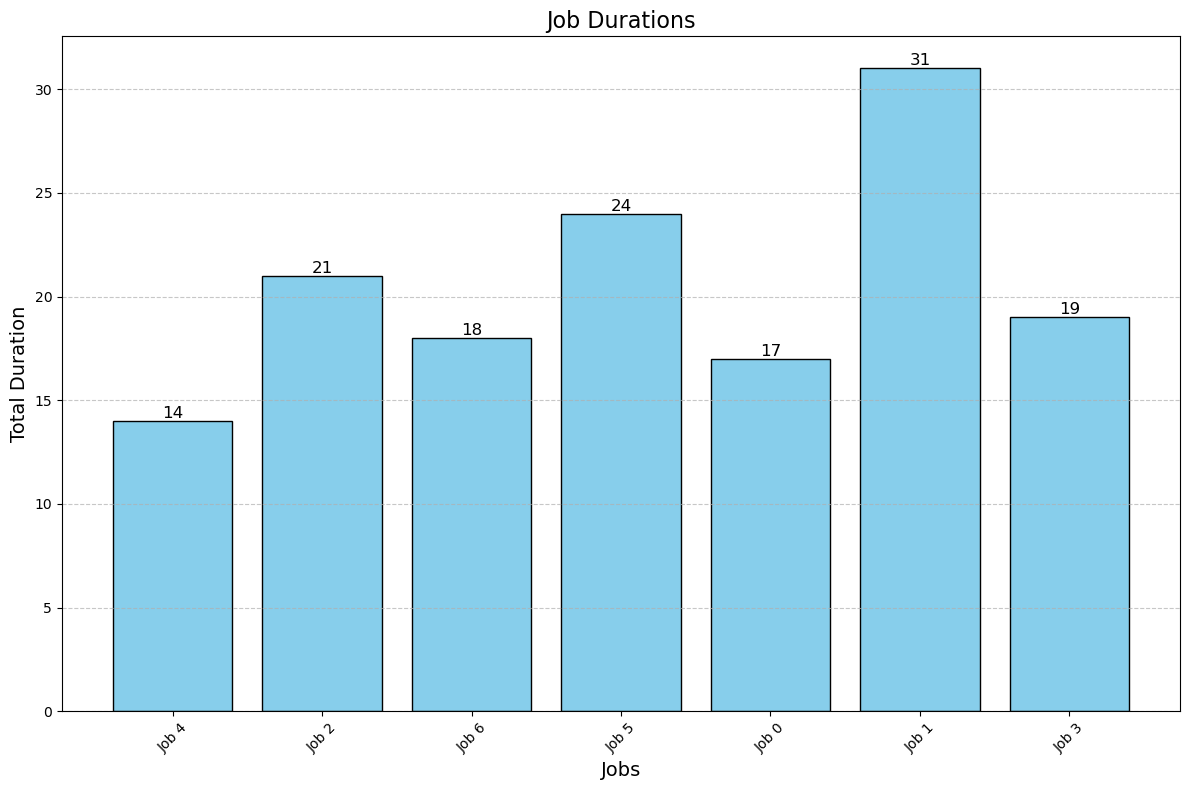

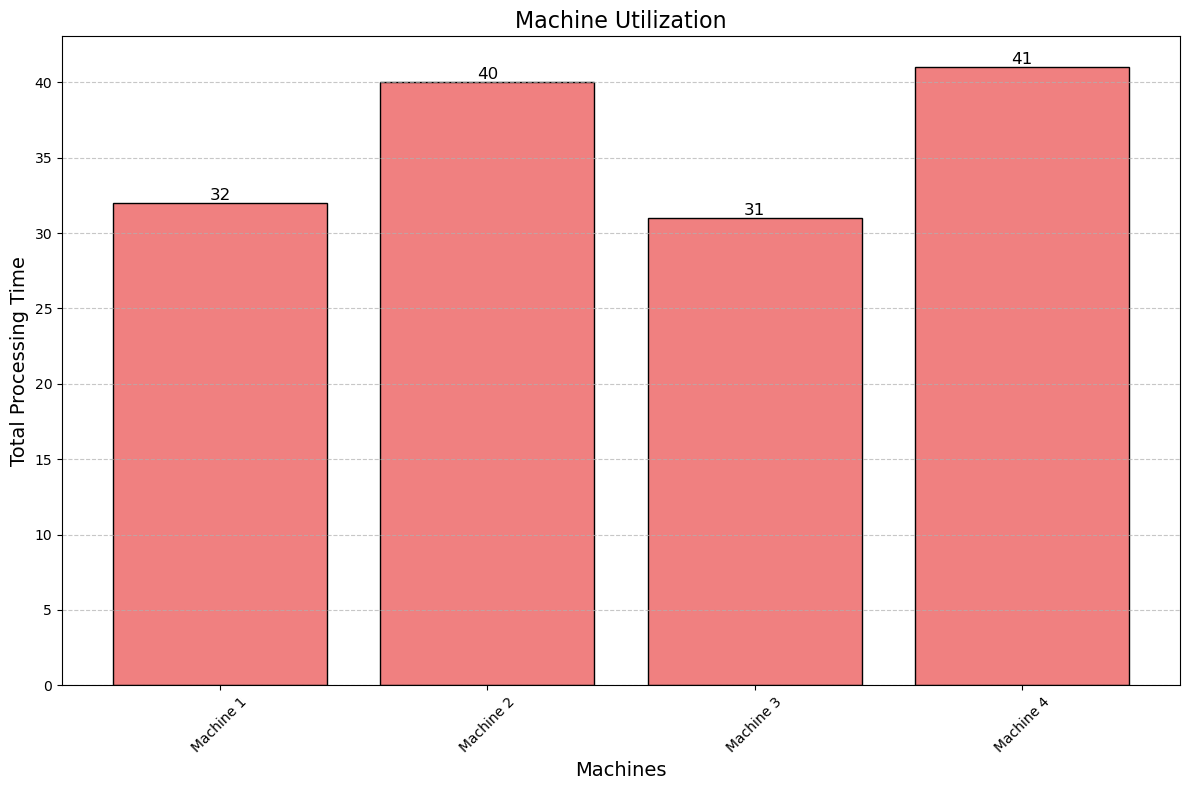

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


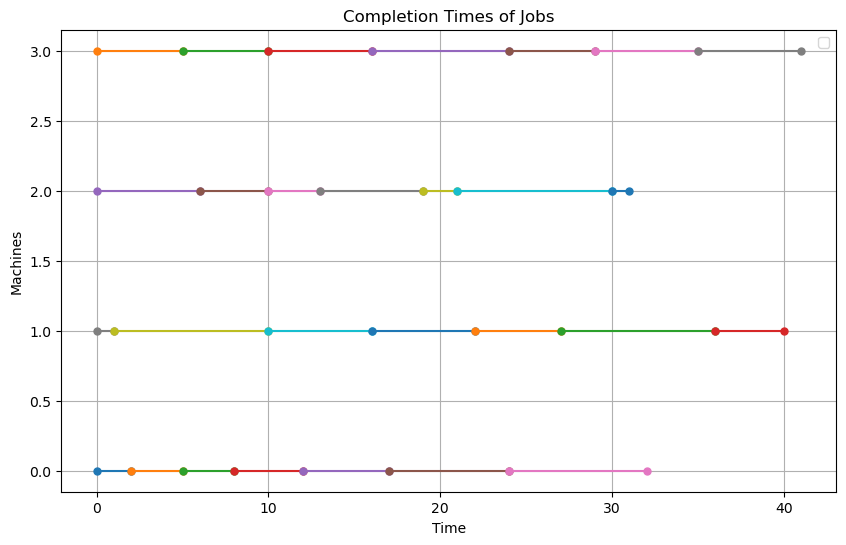

In [15]:
plot_job_durations(PROC, greedy_schedule)
plot_machine_utilization(PROC, greedy_schedule)
plot_completion_times(PROC, greedy_schedule)

## Implementing Genetic Algorithm

In [16]:
def genetic_algorithm(PROC, population_size=100, generations=500, mutation_rate=0.1):
    N_JOBS = len(PROC)

    def create_individual():
        return random.sample(range(N_JOBS), N_JOBS)
    
    def crossover(parent1, parent2):
        crossover_point = random.randint(1, N_JOBS - 2)
        child1 = parent1[:crossover_point] + [job for job in parent2 if job not in parent1[:crossover_point]]
        child2 = parent2[:crossover_point] + [job for job in parent1 if job not in parent2[:crossover_point]]
        return child1, child2
    
    def mutate(individual):
        i, j = random.sample(range(N_JOBS), 2)
        individual[i], individual[j] = individual[j], individual[i]
    
    def fitness(individual):
        return totalTime(PROC, individual)
    
    def roulette_wheel_selection(population, fitness_scores):
        max_fitness = sum(fitness_scores)
        pick = random.uniform(0, max_fitness)
        current = 0
        for individual, score in zip(population, fitness_scores):
            current += score
            if current > pick:
                return individual
    
    population = [create_individual() for _ in range(population_size)]

    fitness_history = []

    for generation in range(generations):
    
        fitness_scores = [1 / fitness(ind) for ind in population]
    
        best_fitness = min(fitness_scores)
        worst_fitness = max(fitness_scores)
        average_fitness = sum(fitness_scores) / len(fitness_scores)
        fitness_history.append({'best': best_fitness, 'worst': worst_fitness, 'average': average_fitness})
        
        next_generation = []
        while len(next_generation) < population_size // 2:
            parent1 = roulette_wheel_selection(population, fitness_scores)
            parent2 = roulette_wheel_selection(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            next_generation.extend([child1, child2])
        
    
        for individual in next_generation[1:]: 
            if random.random() < mutation_rate:
                mutate(individual)
        

        population.extend(next_generation)
        population = sorted(population, key=fitness)[:population_size]
    
    
    best_individual = min(population, key=fitness)
    return best_individual, fitness_history

In [17]:
def plot_fitness_over_generations(fitness_history):
    generations = range(len(fitness_history))
    best_fitness = [entry['best'] for entry in fitness_history]
    worst_fitness = [entry['worst'] for entry in fitness_history]
    average_fitness = [entry['average'] for entry in fitness_history]

    plt.figure(figsize=(10, 6))
    plt.plot(generations, best_fitness, label='Best Fitness', color='green')
    plt.plot(generations, worst_fitness, label='Worst Fitness', color='red')
    plt.plot(generations, average_fitness, label='Average Fitness', color='blue')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Over Generations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
genetic_schedule, fitness_history = genetic_algorithm(PROC)
print("Genetic Algorithm Schedule:", genetic_schedule)
print("Total Time (Genetic):", totalTime(PROC, genetic_schedule,log=True))
print_schedule(PROC, genetic_schedule, show_idle_times=True, include_summary=True)

Genetic Algorithm Schedule: [6, 4, 0, 5, 1, 3, 2]
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    3 |            | Idle:    9 |            | Idle:   12 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   3 |            | Start:   9 |            | Start:  12 |
| Job:  6 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    6 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    6 |
|         |            | Stop:    3 |            | Stop:    9 |            | Stop:   12 |            | Stop:   18 |
|---------|-----------

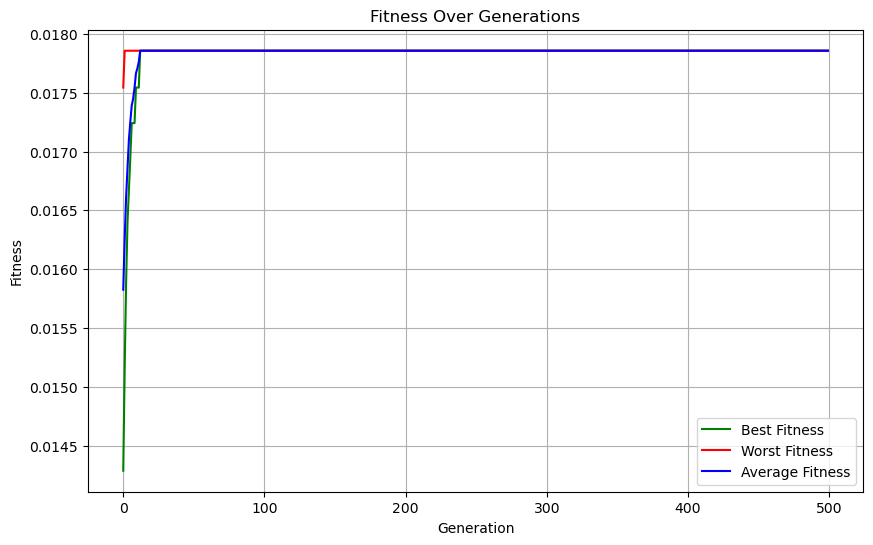

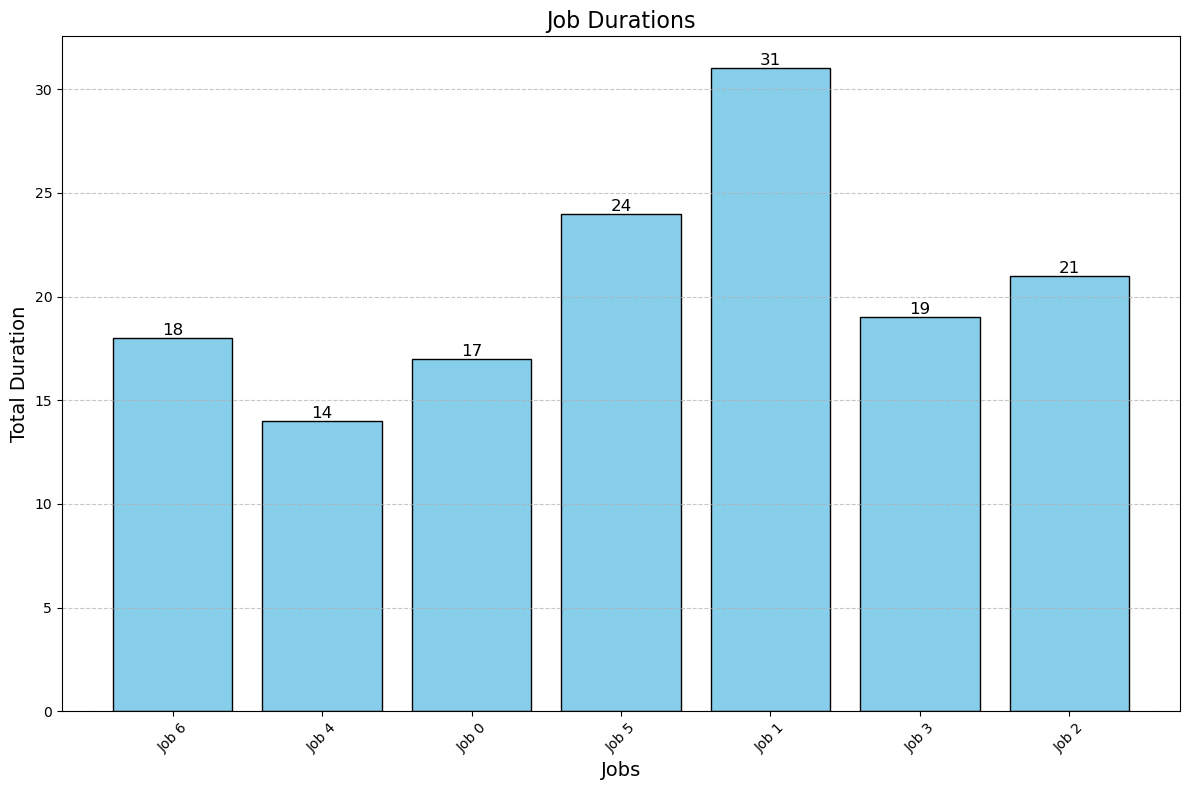

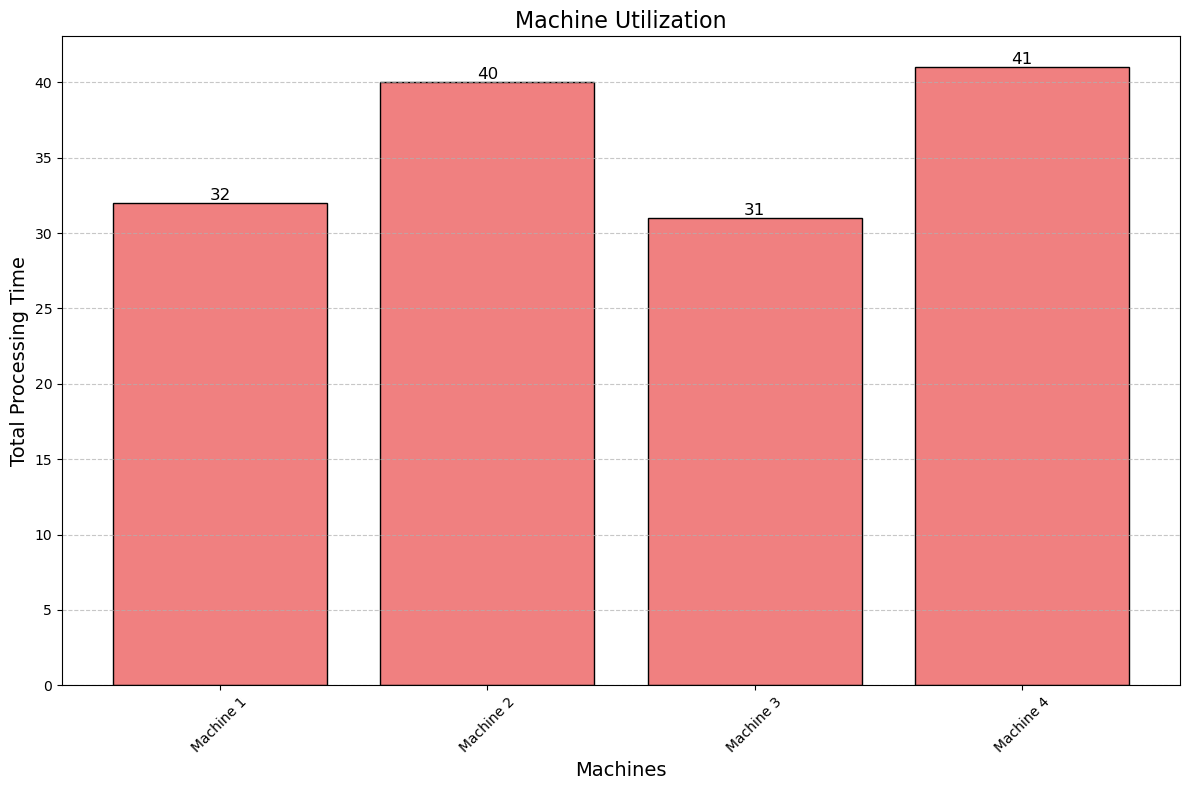

In [21]:
plot_fitness_over_generations(fitness_history)
plot_job_durations(PROC,genetic_schedule)
plot_machine_utilization(PROC,genetic_schedule)